<a href="https://colab.research.google.com/github/EliseuODaniel/Analise_temperatura_motor_eletrico/blob/main/analise_3_Polynomial_Regressionl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomial Regression

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import os

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/notebooks/input/measures_v2.csv')
df.shape

(1330816, 13)

In [3]:
from sklearn.preprocessing import PolynomialFeatures

In [4]:
# remoção da coluna torque, pois não servirá como variável nem de entrada e nem de saída
df.drop('torque', axis=1, inplace=True)

#Separação entre Datasets de treino e de teste

In [5]:
#testagens separadas pra teste
test_set_profiles = range(65,73)
x_cols = ['ambient', 'coolant','i_q', 'u_q','i_d', 'u_d', 'motor_speed'] #RMSE = 10.51 (com todas as variáveis)
#x_cols = ['ambient', 'coolant','i_q', 'u_q','i_d', 'u_d'] #RMSE = 12.06 (sem motor_speed)
#x_cols = ['ambient', 'coolant','i_q', 'u_q','i_d',  'motor_speed'] #RMSE =  10.55
#x_cols = ['ambient', 'coolant','i_q', 'u_q', 'u_d', 'motor_speed'] #RMSE = 11.79
#x_cols = ['ambient', 'coolant','i_q', 'i_d', 'u_d', 'motor_speed'] #RMSE = 12.22
#x_cols = ['ambient', 'coolant', 'u_q','i_d', 'u_d', 'motor_speed'] #RMSE = 10.36 (sem i_q - melhor resultado)
#x_cols = ['ambient', 'i_q', 'u_q','i_d', 'u_d', 'motor_speed'] #RMSE = 11.38
#x_cols = [ 'coolant','i_q', 'u_q','i_d', 'u_d', 'motor_speed'] #RMSE = 11.01

#separado 2 datasets, um com as testagens que serão usadas pra treino e outro as de teste
trainset = df.loc[~df.profile_id.isin(test_set_profiles), :].reset_index(drop=True)
testset = df.loc[df.profile_id.isin(test_set_profiles), :].reset_index(drop=True)


X_train = trainset.loc[:, x_cols]
y_train = trainset.loc[:, 'pm']
X_test = testset.loc[:, x_cols]
y_test = testset.loc[:, 'pm']

a variável motor_speed cria resíduos distantes da média, como outliers. Talvez pela unidade da medida de velocidade.

In [6]:
X_train.shape

(1148796, 7)

In [7]:
X_test.shape

(182020, 7)

# Modelagem

In [8]:
polynomial_converter = PolynomialFeatures(degree=2,include_bias=False)

In [9]:
# Converter "fits" to data, in this case, reads in every X column
# Then it "transforms" and ouputs the new polynomial data
X_train_poly_features = polynomial_converter.fit_transform(X_train)
X_test_poly_features = polynomial_converter.fit_transform(X_test)

In [10]:
X_train_poly_features.shape

(1148796, 35)

In [11]:
X_test_poly_features.shape

(182020, 35)

In [12]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_poly_features,y_train)
test_predictions = model.predict(X_test_poly_features)

# Mensuração dos erros

In [13]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [14]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [15]:
MAE

8.121261553539135

In [16]:
MSE

110.47258994617297

In [17]:
RMSE

10.51059417664734

In [18]:
#valor médio das temperaturas do rotor em todo o dataset - para comparar com o RMSE
#ou seja, as previsões do modelo variam 12 para + e - de 58,51
df['pm'].mean()

58.50677585061459

Comparison with multiple linear regression  
MAE = 9.626260043968127  
MSE = 145.61949126832434   
RMSE = 12.067290137736986 

In [19]:
model.coef_

array([-9.93535005e+00,  1.40102607e+00, -7.75913016e-02, -1.13689428e+00,
       -3.52007918e-01, -2.25577035e+00,  8.87746876e-02,  3.42470931e-01,
       -3.97550142e-02, -1.31863397e-03, -2.45873556e-02, -3.60042922e-04,
        1.25726976e-02, -3.87792866e-04, -1.58548367e-03,  6.59811720e-05,
        2.96787620e-03, -1.45692693e-03,  1.80325691e-03, -1.33145911e-04,
        7.57587966e-06, -1.41835252e-02, -1.75697633e-03, -1.17726225e-03,
        2.65587087e-04, -6.24152582e-03,  9.61577208e-03,  3.95196116e-03,
        4.08292748e-04, -2.32474616e-03, -1.32206296e-02,  2.43315895e-04,
        1.02513274e-03, -3.90729119e-05, -3.78633379e-06])

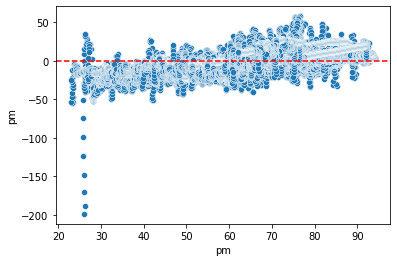

In [20]:
# plotagem da distribuição dos resíduos
test_res = y_test - test_predictions

sns.scatterplot(x=y_test,y=test_res)
plt.axhline(y=0, color='r', linestyle='--')

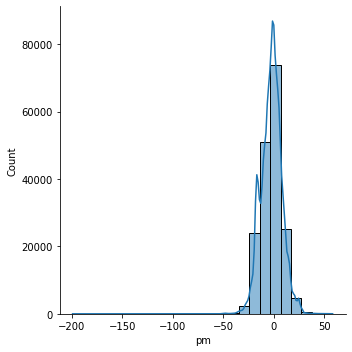

In [21]:
#plotagem da distribuição dos resíduos pra verificar visualmente a normalidade
sns.displot(test_res,bins=25,kde=True)

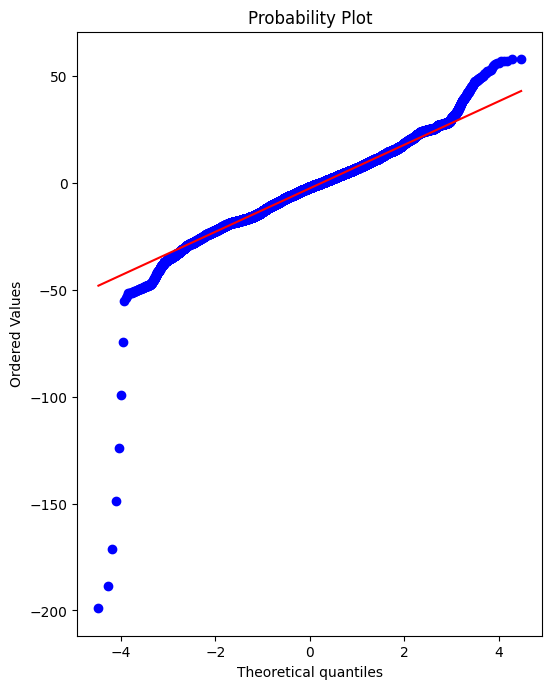

In [22]:
import scipy as sp
# Create a figure and axis to plot on
fig, ax = plt.subplots(figsize=(6,8),dpi=100)
# probplot returns the raw values if needed
# we just want to see the plot, so we assign these values to _
_ = sp.stats.probplot(test_res,plot=ax)

os resíduos distantes da normal devem-se à variável motor_speed como mencionado mais acima

In [24]:
import statsmodels.api as sm
X_train_const = sm.add_constant(X_train_poly_features)
lin_reg = sm.OLS(y_train,X_train_const).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pm   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                 1.218e+05
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        07:47:25   Log-Likelihood:            -4.1610e+06
No. Observations:             1148796   AIC:                         8.322e+06
Df Residuals:                 1148760   BIC:                         8.322e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.2253      1.228     62.903      0.000      74.819      79.632
x1            -9.9354      0.108    -91.933      0.000     -10.147      -9.724
x2             1.4010      0.009    148.598      0.000       1.383       1.420
x3            -0.0776      0.003    -25.354      0.000      -0.084      -0.072
x4            -1.1369      0.008   -141.096      0.000      -1.153      -1.121
x5            -0.3520      0.006    -59.568      0.000      -0.364      -0.340
x6            -2.2558      0.007   -312.025      0.000      -2.270      -2.242
x7             0.0888      0.000    270.437      0.000       0.088       0.089
x8             0.3425      0.002    142.273      0.000       0.338       0.347
x9            -0.0398      0.000   -101.822      0.000      -0.041      -0.039
x10           -0.0013      0.000    -10.574      0.000      -0.002      -0.001
x11           -0.0246      0.000    -83.796      0.000      -0.025      -0.024
x12           -0.0004      0.000     -1.742      0.081      -0.001     4.5e-05
x13            0.0126      0.000     72.870      0.000       0.012       0.013
x14           -0.0004   1.06e-05    -36.710      0.000      -0.000      -0.000
x15           -0.0016   2.35e-05    -67.545      0.000      -0.002      -0.002
x16         6.598e-05   1.12e-05      5.880      0.000     4.4e-05     8.8e-05
x17            0.0030   2.66e-05    111.547      0.000       0.003       0.003
x18           -0.0015   1.95e-05    -74.871      0.000      -0.001      -0.001
x19            0.0018   1.68e-05    107.629      0.000       0.002       0.002
x20           -0.0001    9.7e-07   -137.306      0.000      -0.000      -0.000
x21         7.576e-06      5e-06      1.516      0.130   -2.22e-06    1.74e-05
x22           -0.0142   8.56e-05   -165.695      0.000      -0.014      -0.014
x23           -0.0018   7.49e-06   -234.514      0.000      -0.002      -0.002
x24           -0.0012   9.07e-06   -129.839      0.000      -0.001      -0.001
x25            0.0003   4.12e-06     64.433      0.000       0.000       0.000
x26           -0.0062   2.55e-05   -244.885      0.000      -0.006      -0.006
x27            0.0096   3.38e-05    284.177      0.000       0.010       0.010
x28            0.0040   2.29e-05    172.277      0.000       0.004       0.004
x29            0.0004   1.58e-06    257.856      0.000       0.000       0.000
x30           -0.0023   1.18e-05   -196.846      0.000      -0.002      -0.002
x31           -0.0132   5.71e-05   -231.377      0.000      -0.013      -0.013
x32            0.0002   1.09e-06    223.495      0.000       0.000       0.000
x33            0.0010   1.08e-05     94.986      0.000       0.001       0.001
x34        -3.907e-05   5.55e-07    -70.442      0.000   -4.02e-05    -3.8e-05
x35        -3.786e-06   2.65e-08   -143.030      0.000   -3.84e-06   -3.73e-06
==